###  Import libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

'0.12.0'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

####  Make a folder to save graph

In [4]:
# Make folder to save plots
save_folder = "/data2/lidongwei/work/work_scMultiome/part_cellOracle/output/05_simulation/figures"
os.makedirs(save_folder, exist_ok=True)

###  Load data



In [5]:
oracle = co.load_hdf5("/data2/lidongwei/work/work_scMultiome/part_cellOracle/output/Network_analysis/rice_root.celloracle.oracle")
oracle


Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 31108
    n_genes: 5000
    cluster_name: seurat_annotations
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 25457 genes
    n_regulatory_in_TFdict: 270 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 71 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 3375 genes
    k_for_knn_imputation: 777
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [6]:
links = co.load_hdf5(file_path="/data2/lidongwei/work/work_scMultiome/part_cellOracle/output/Network_analysis/rice_root_links.celloracle.links")

### Make predictive models for simulation
Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)



  0%|          | 0/9 [00:00<?, ?it/s]

### In silico TF perturbation analysis



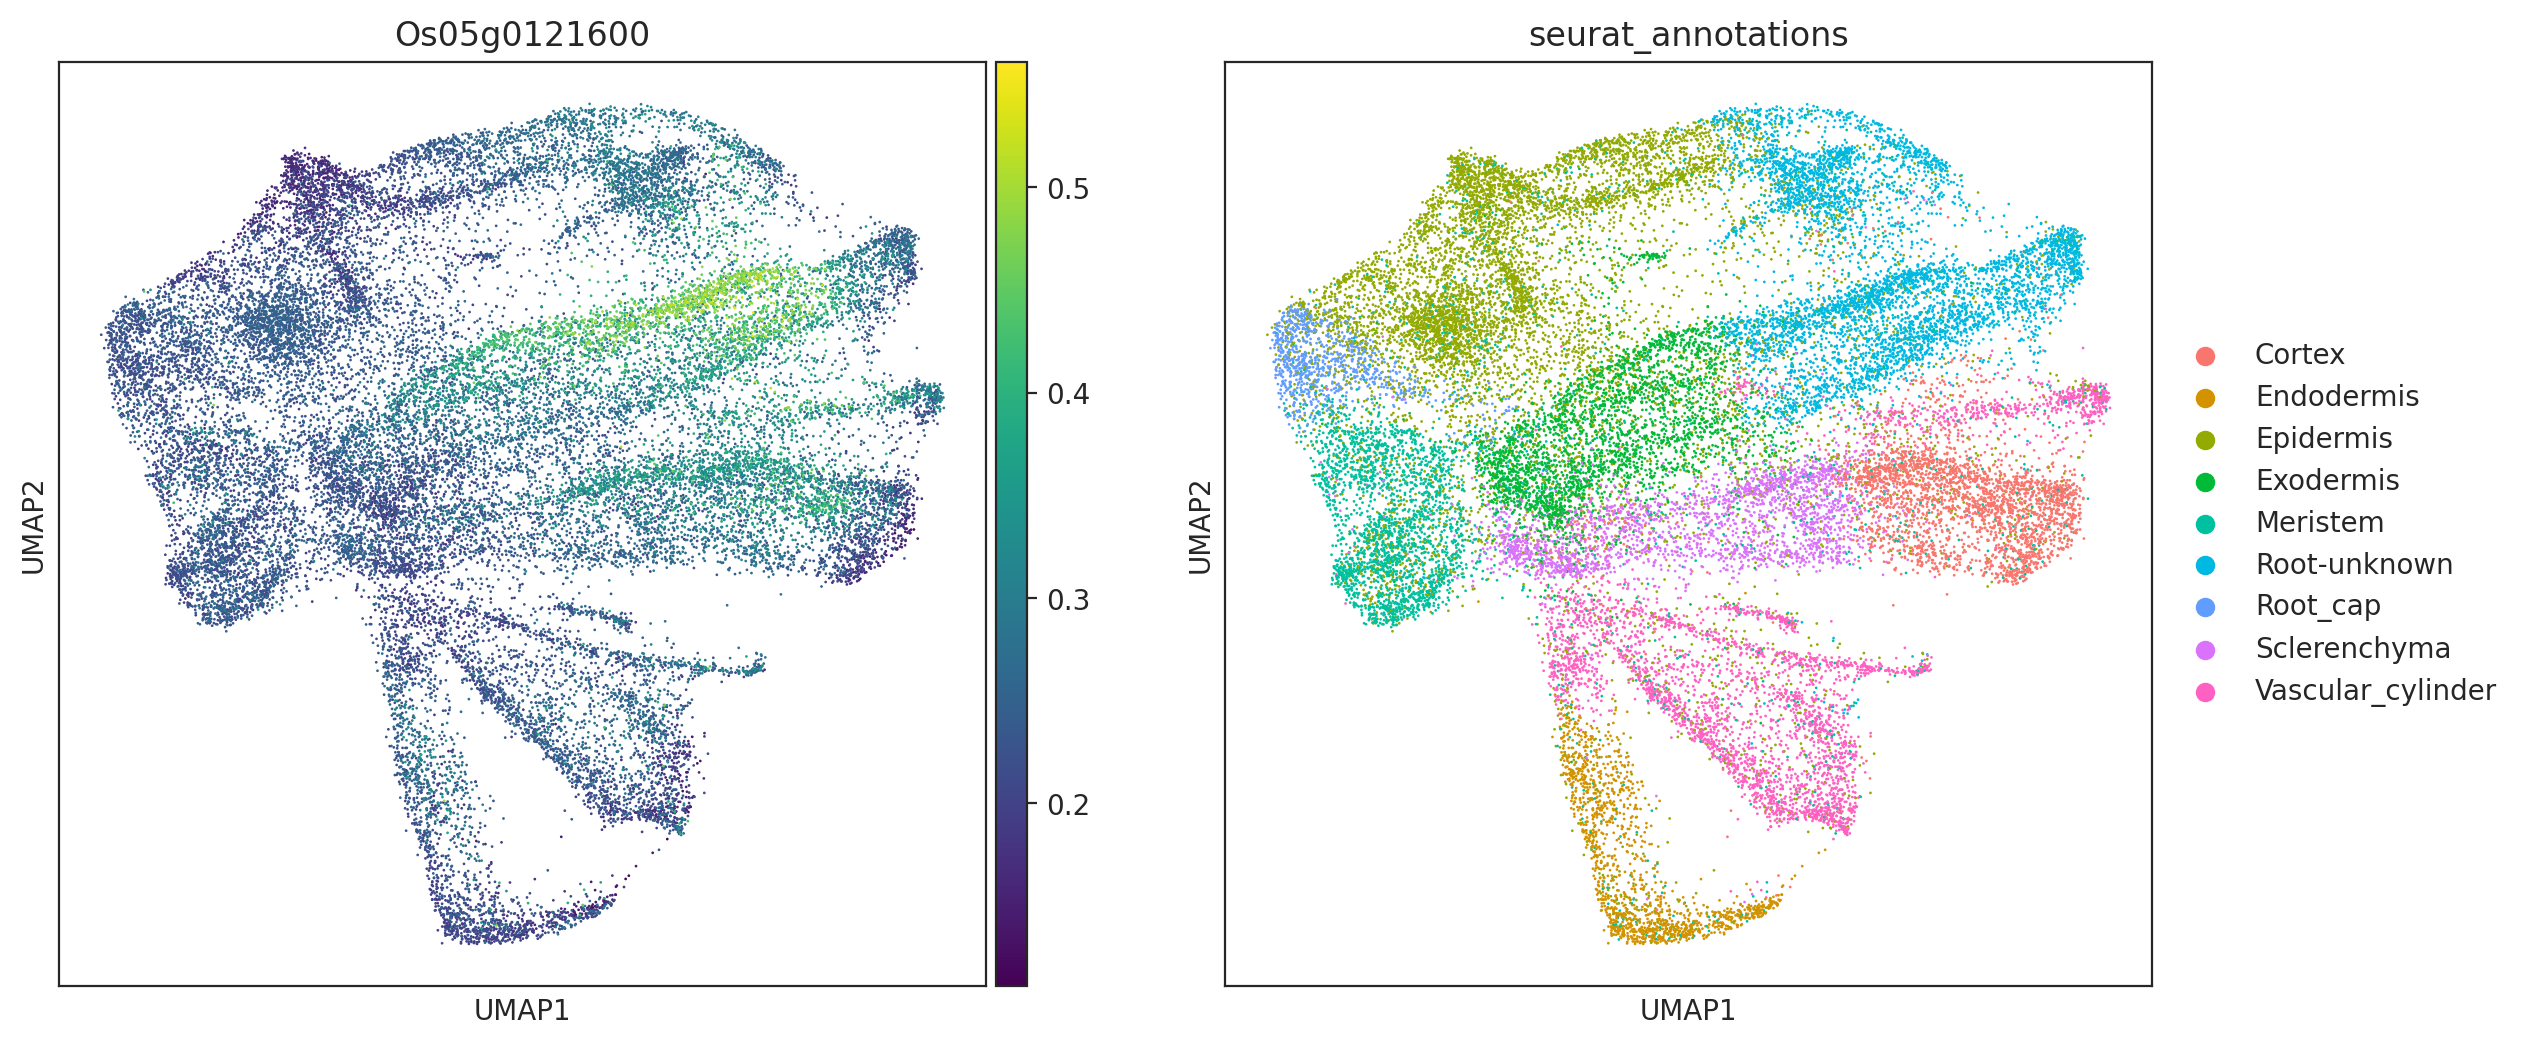

In [8]:
# Check gene expression 
goi = "Os05g0121600" # RSR1 : Os05g0121600
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name], 
                 layer="imputed_count", use_raw=False, cmap="viridis")


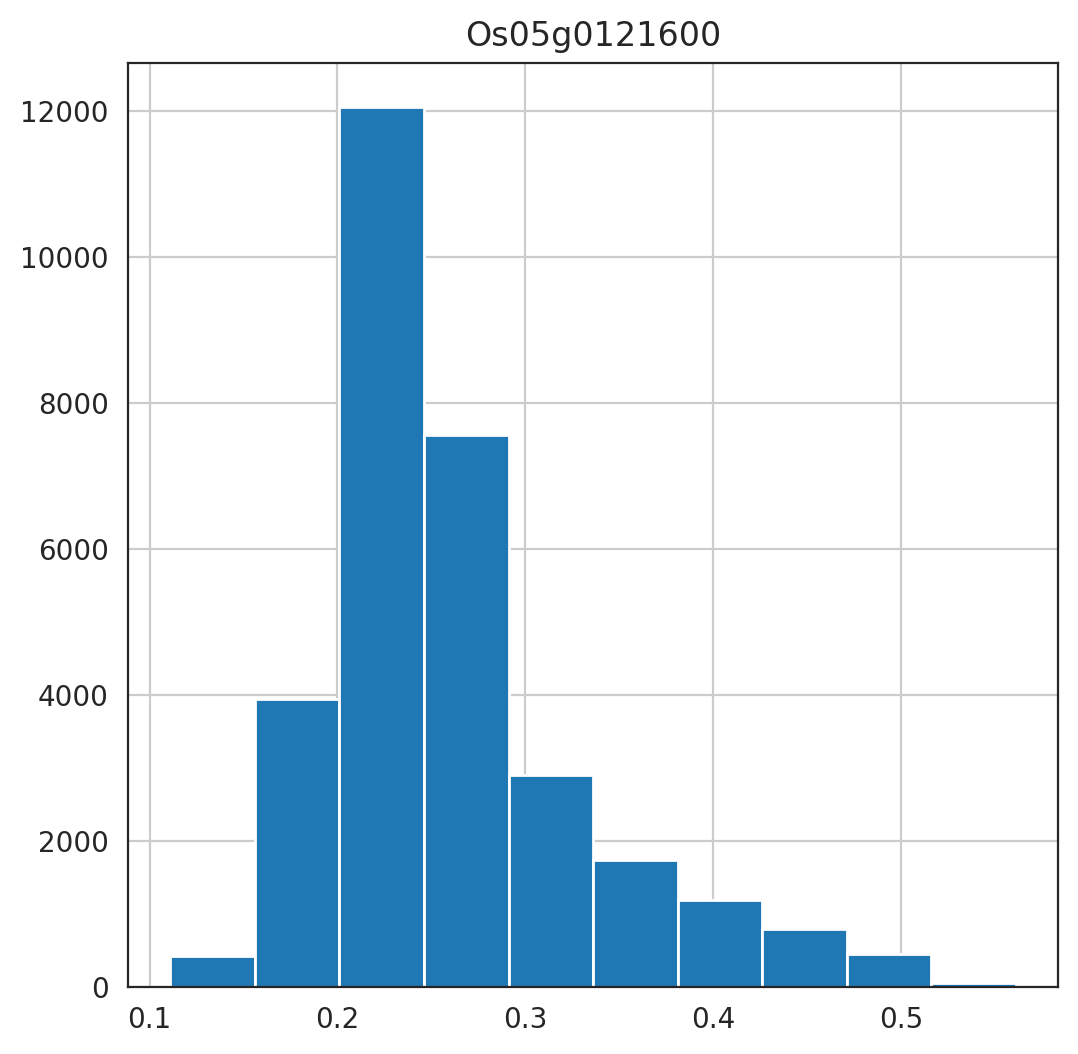

In [9]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

###  Calculate future gene expression after perturbation.


In [10]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
goi = "Os05g0121600"
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

#####  Calculate transition probability between cells

In [11]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr=0.05)

###  Visualization
####  Quiver plot: Show the direction of cell transition at single 

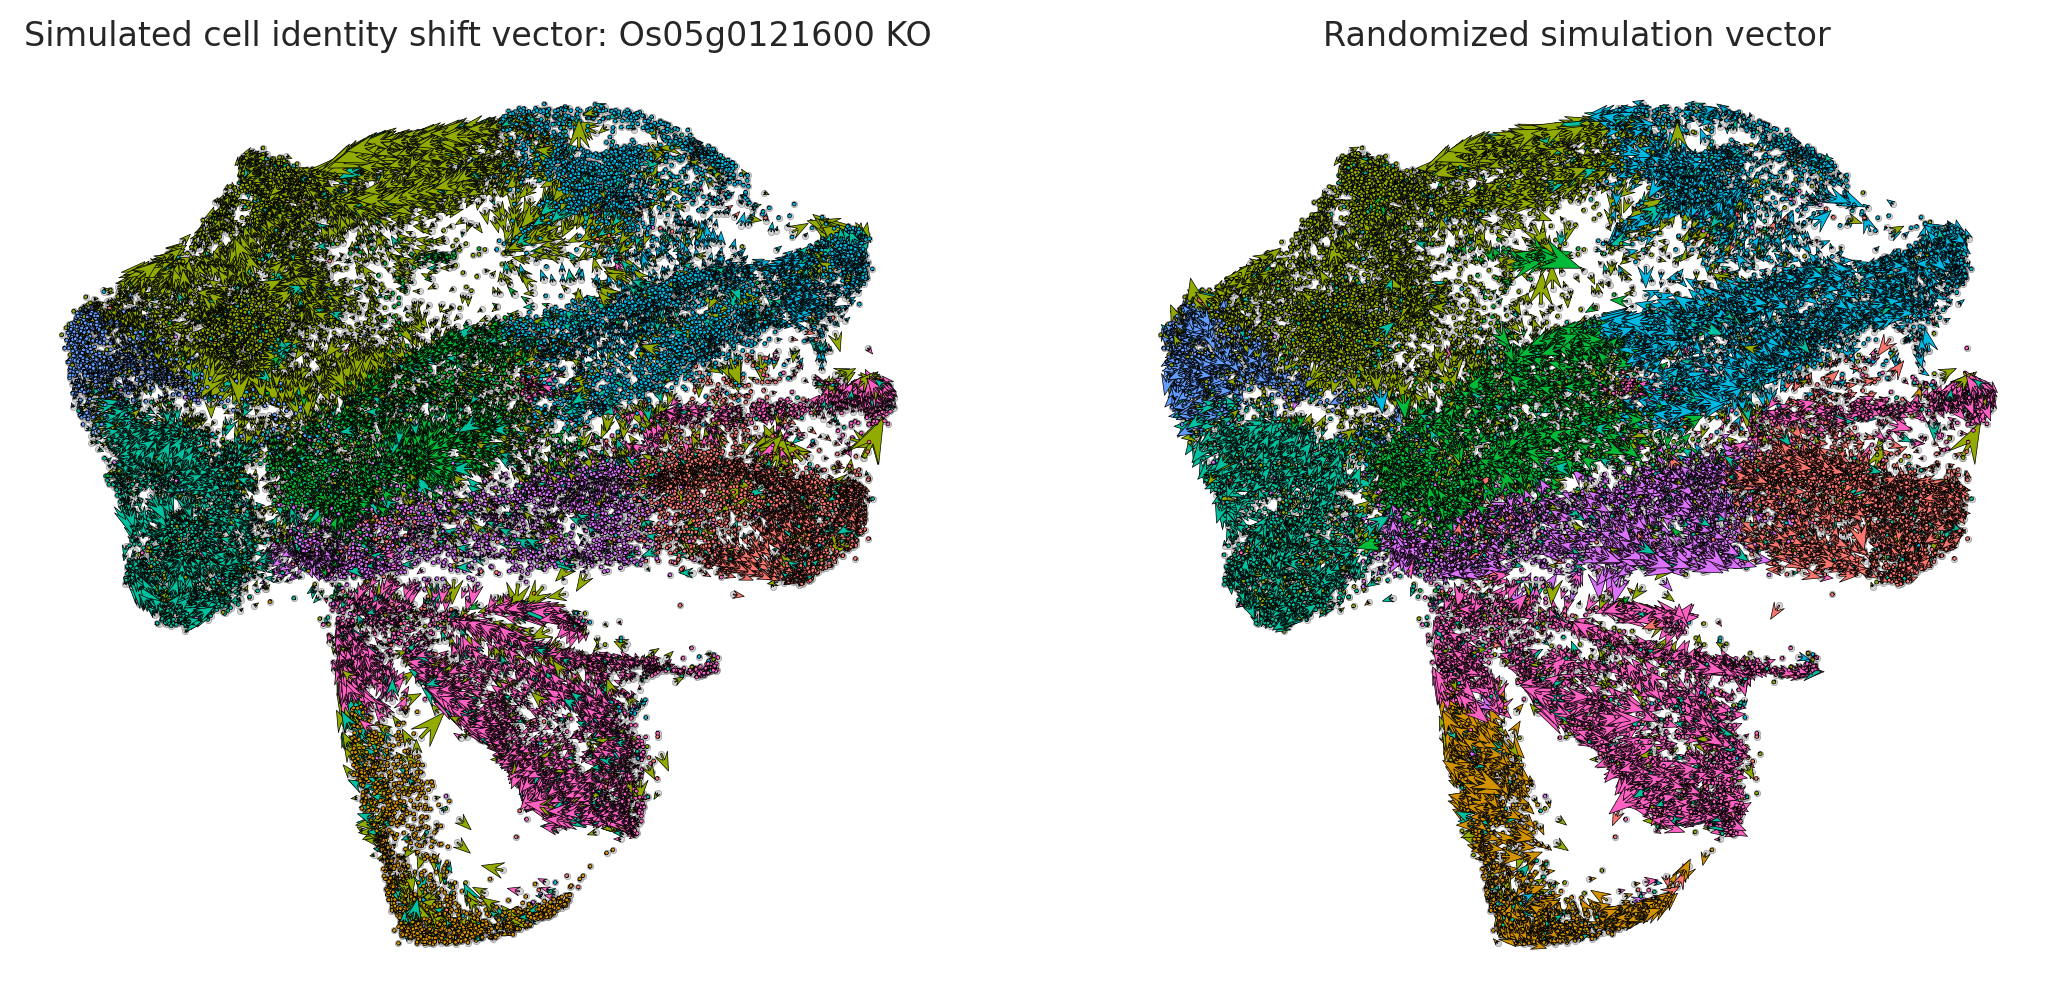

In [27]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25  
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

####  Vector field graph

#####  Find parameters for n_grid and min_mass
n_grid: Number of grid points.

min_mass: Threshold value for the cell density. The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.

In [33]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

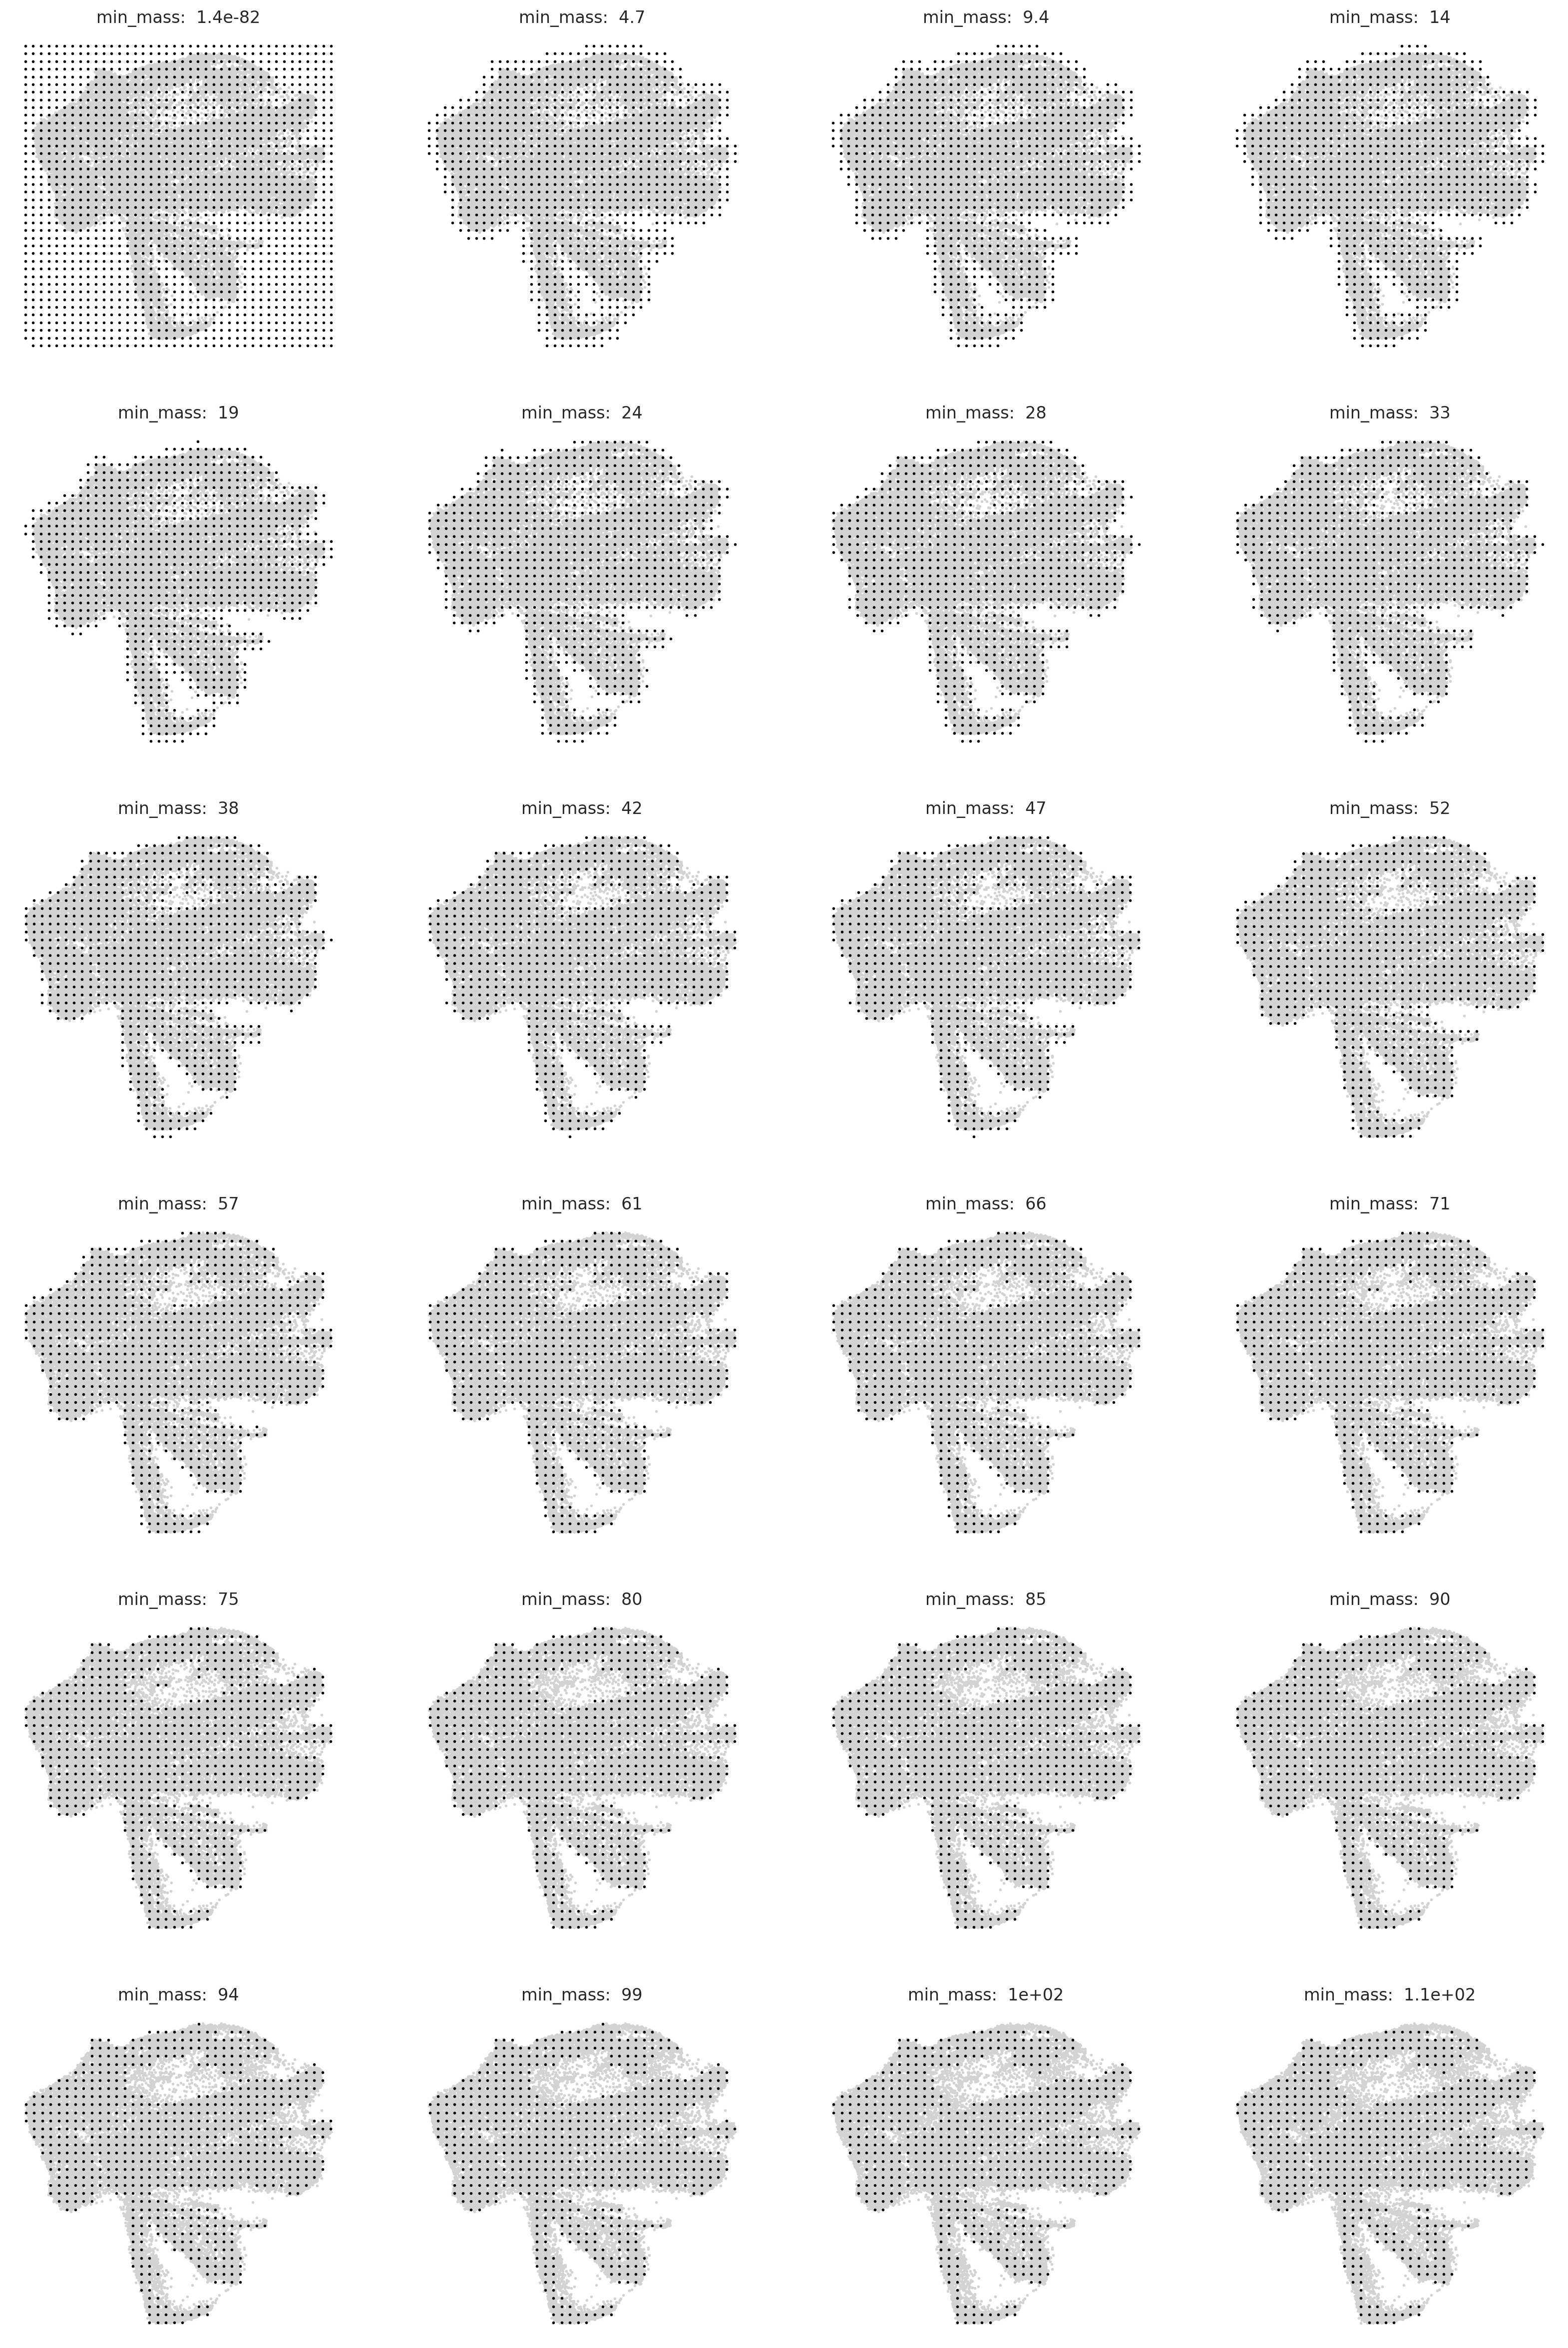

In [35]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=24)

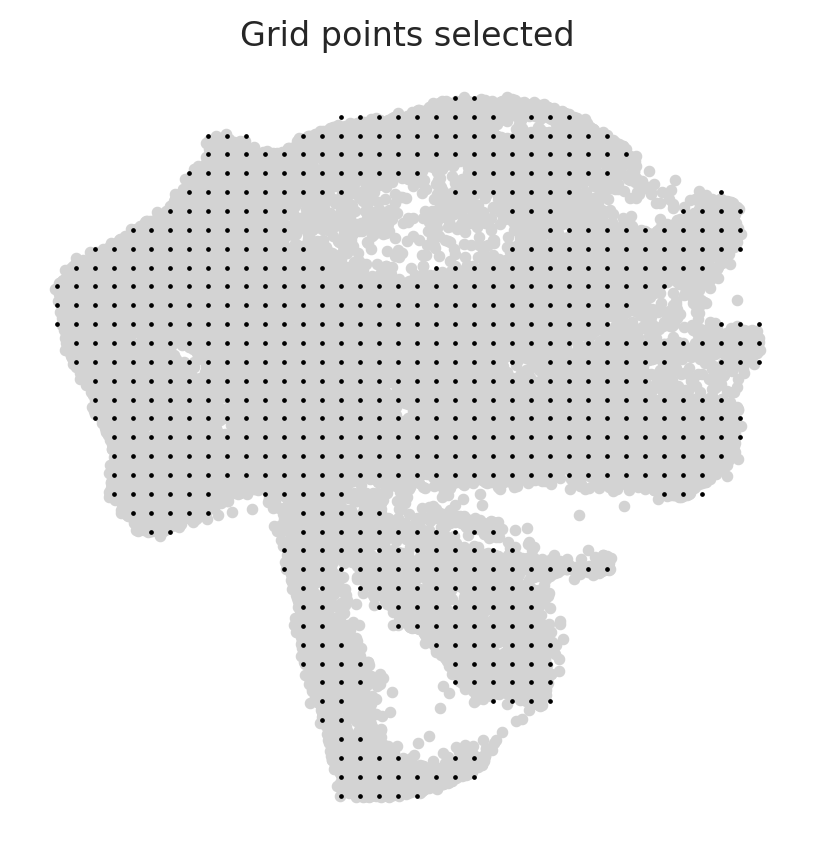

In [36]:
min_mass = 90
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

#####  Plot vector fields


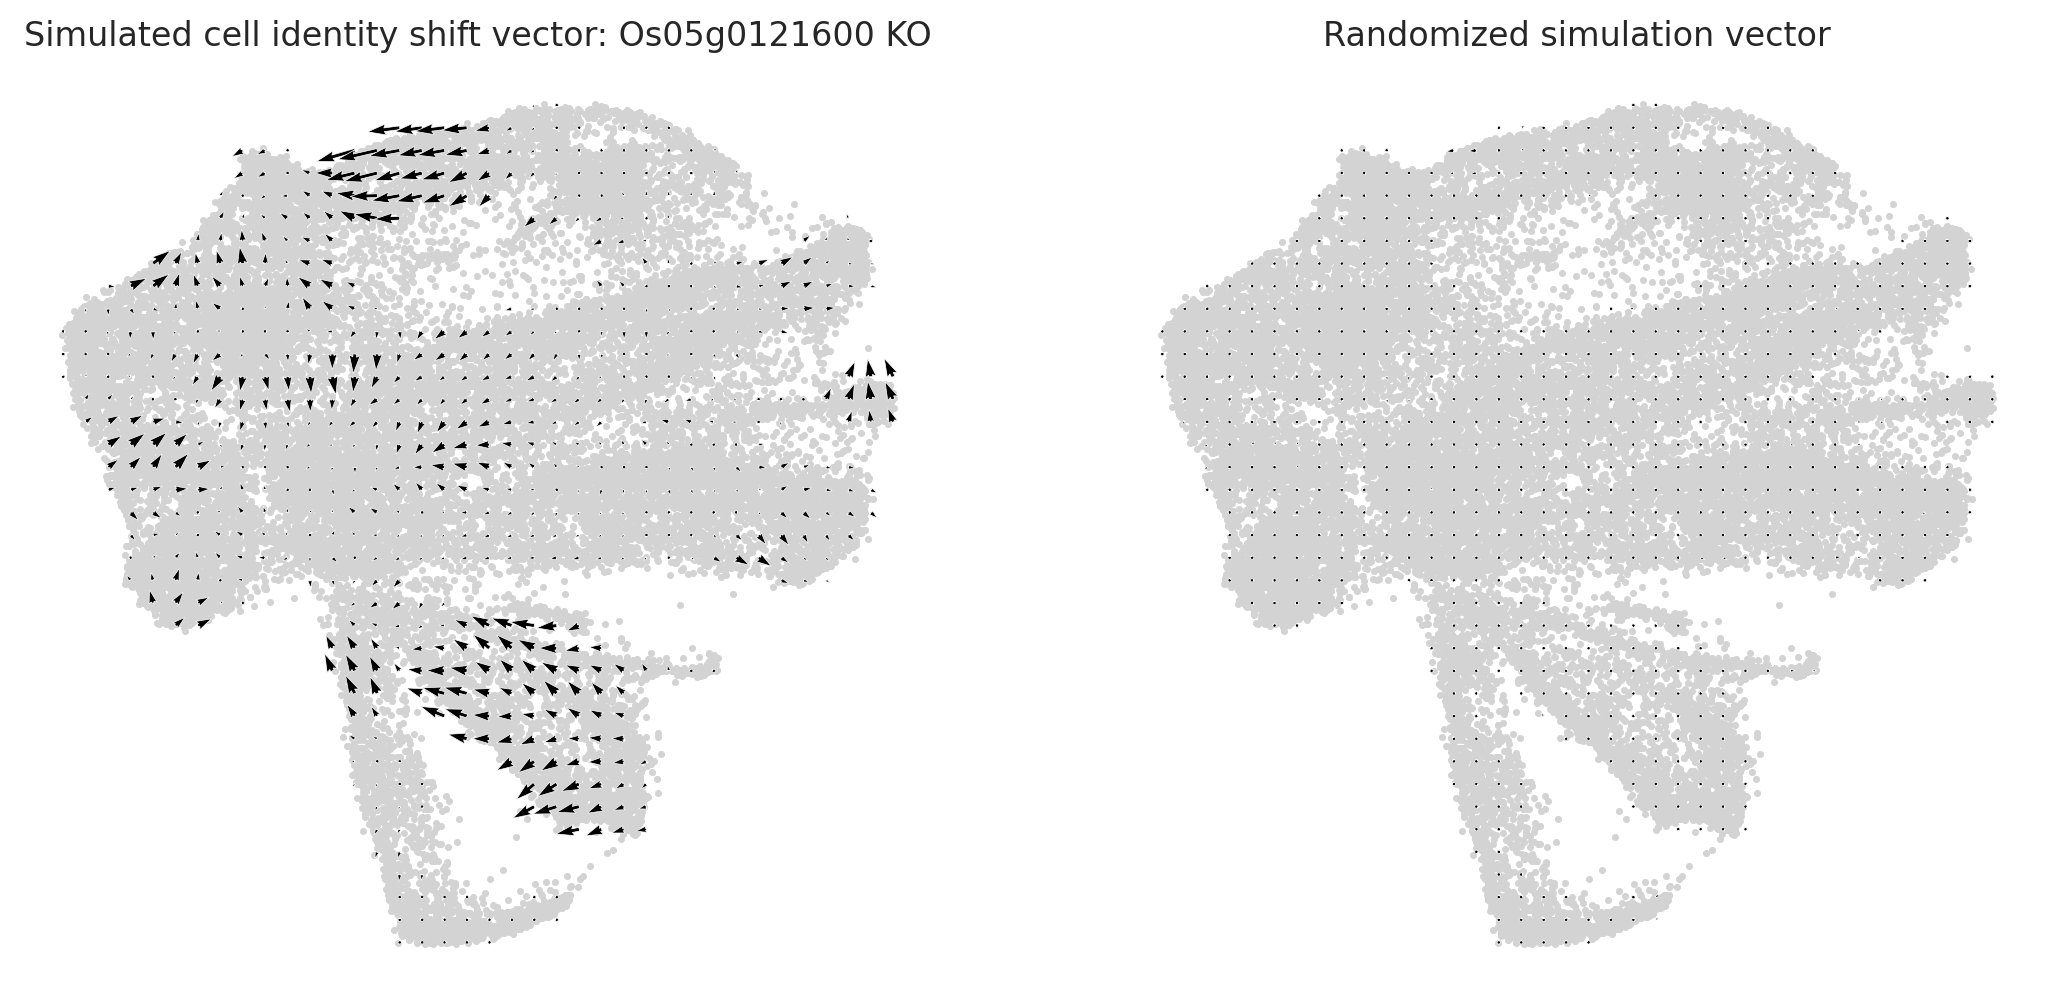

In [37]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 15 
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

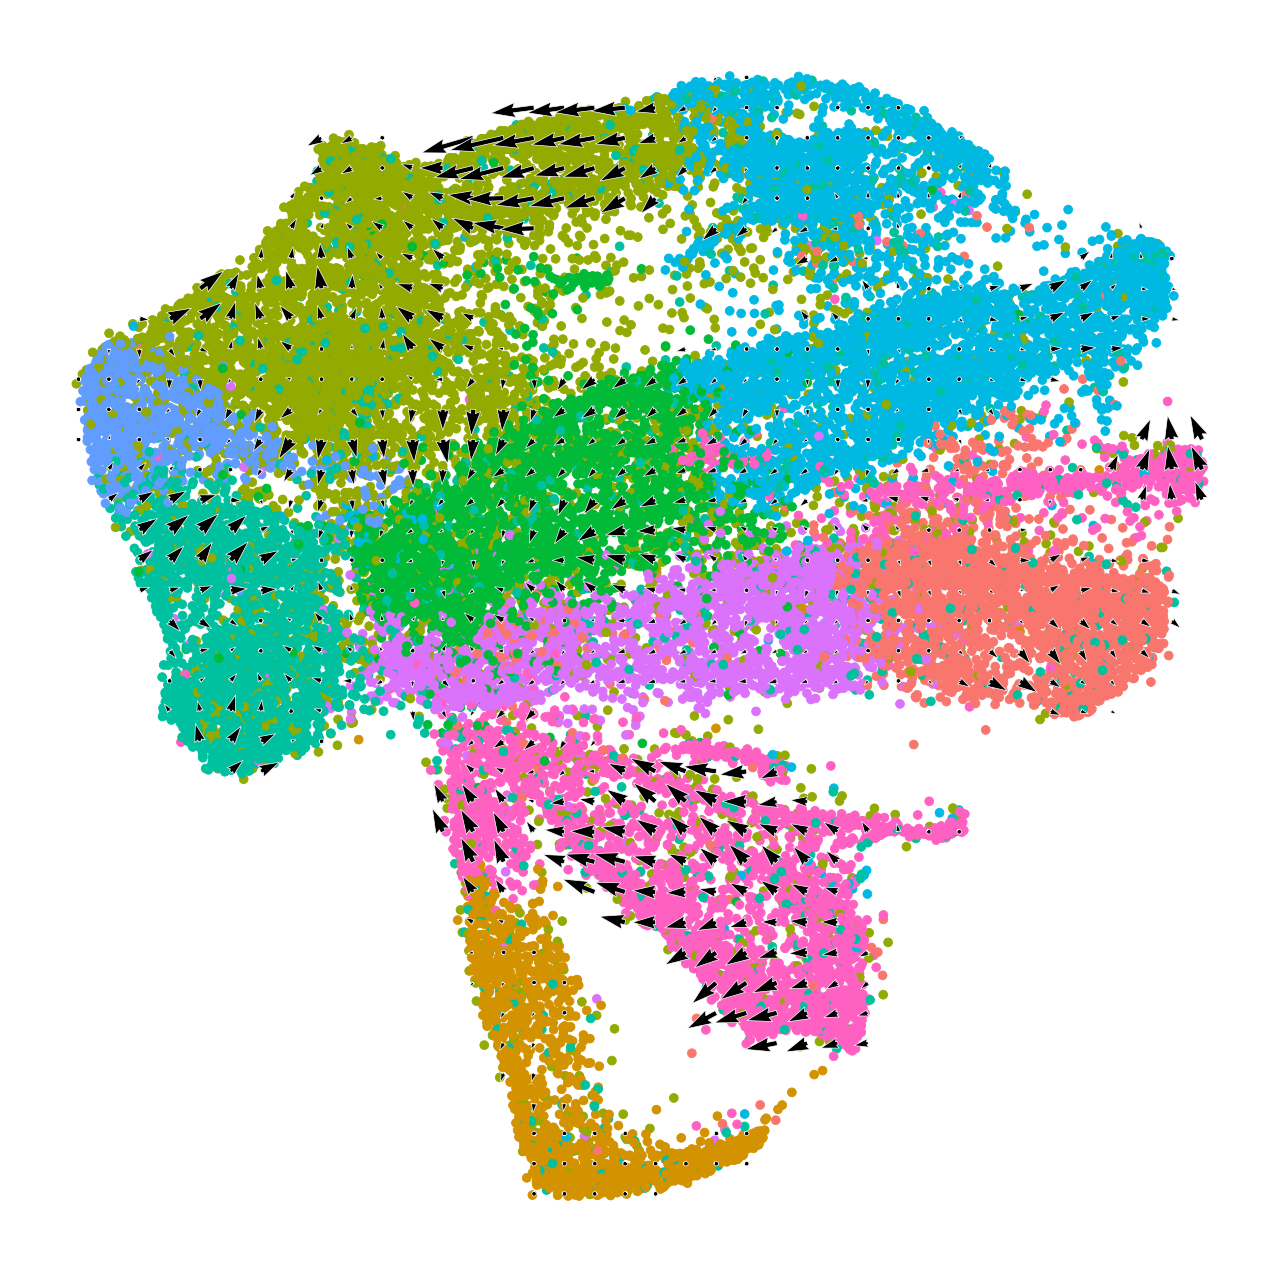

In [38]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)